# Evaluation on Mandarin Language Models

This script evaluates the performance of 5 Mandarin language models ($n$-gram, LSTM, RNNG, Transformer, PLM), each trained on the CTB and hybrid Xinhua news dataset (CTB data included), denoted as X and X-Xinhua (e.g. LSTM, LSTM-Xinhua). We consider 6 test casese: Classifier-Noun Compatibility, Garden Path subject, Garden Path object, Missing Object, Verb-Noun Compatibility, and Subordination.


### Overview
1. Compute surprisal differences based on test suite class
2. Compute accuracy scores for each model and store the results
3. Visualizations (figures and tables)

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import matplotlib
from scipy import stats
import statsmodels.api as sm
np.random.seed(2021)

## Data Prep

In this section, we read in models' results. Each file shows a model + seed + test_suite_class + modifier_type combination. We compute surprisal differences (Ungrammatical - Grammatical) based on the **test suite class**, since each test suite class has its unique criterion. Then, in each file, the accuracy scores is computed by averaging a 0/1 score assessing whether the surprisal difference is positive across all the test items.

To faciliate later steps that visualize the results, we group the accuracy scores into different dictionaries/lists.
1. `df_tables`: a list of summary tables for each test suite class + modifier type (e.g. Classifier - None), contains mean and std for each model's accuracy scores 
2. `dic_by_model`: aggregating test suite classes, one entry per model type (e.g. LSTM-Xinhua)
3. `dic_by_test`: aggregating model types, one entry per test suite class (e.g. Classifier)
4. `dic_by_mt`: one entry per model type + test suite class (e.g. (Classifier, LSTM-Xinhua))
5. `dic_by_mt_no`: one entry per model type + test suite class (e.g. (Classifier, LSTM-Xinhua)), exlcudes no modifier case
6. `dic_by_mt_none`: one entry per model type + test suite class, considers only the no modifier case (e.g. (Classifier - None, LSTM-Xinhua)), exlcudes no modifier case
7. `full_results`: one entry per model type + test suite class + modifier type (e.g. ((Classifier, None), LSTM)), which is useful when we want to add modifier type as a random effect


### Functions that read in raw surprisals and compute accuracy scores based on test suite classes

In [3]:
def compute_diff(df,col=4):
    '''Compute the surprisal difference: Ungrammatical - Grammatical'''
    if col == 4:
        return [df['U1']-df['G1'],df['U2']-df['G2'],df['U2']-df['G1'],df['U1']-df['G2']]
    else:
        return [df['U']-df['G']]

In [4]:
def compute_diff_values(df,col=4):
    if col == 4:
        return [df['U1'].values-df['G1'].values,df['U2'].values-df['G2'].values,df['U2'].values-df['G1'].values,df['U1'].values-df['G2'].values]
    else:
        return [df['U']-df['G']]

In [5]:
def compute_cls_mean(pairs, breakTie):
    '''Calculate the accuracy across all four U&G pairs'''
    acc_total = []
    for pair in pairs:
        acc_total.append(calc_accuracy(pair, breakTie=breakTie))
    acc_total = np.mean(acc_total)
    return acc_total

In [6]:
def calc_accuracy(data,breakTie=False):
    '''Calculate the proportion of the test suites that the model predicts correctly'''
    if breakTie:
        success = [np.random.randint(2) if i == 0 else i for i in data]
        success_rate = [i for i in success if i > 0]
        return len(success_rate)/len(data)
    else:
        return sum(data>0)/len(data)

In [7]:
def calc_difference(data):
    '''Record 1 if the model gets the test suite item correctly and 0 otherwise'''
    print(len(data))
    diff_list = []
    if len(data) == 4:
        for pair in data:
            diff_list.extend([1 if i > 0 else 0 for i in pair])
    else:
        diff_list = [1 if i > 0 else 0 for i in data] 
    print(len(diff_list))
    return diff_list

In [8]:
def evaluate_with_mean(model_path = '../OpenMind/lstm_outputs/', model = 'lstm',
             test = 'Missing_Object' , modifier = 'none', plot=True,annotate=True,no_acc=False):
    '''Evaluate the surprisal files for the LSTM, RNNG and Transformer models. Returns a summary table and/or 
        histogram and sentences with annotations.'''
    
    # abbreviation mapping
    if test == 'Classifier':
        abs_test = 'cls'
    elif test == 'Missing_Object':
        abs_test = 'mobj'
    elif test == 'Verb_Noun':
        abs_test = 'vo'
    elif test == 'Subordination':
        abs_test = 'sd'
    elif test == 'GP_obj':
        abs_test = 'gpo'
    elif test == 'GP_sub':
        abs_test = 'gps'
        # original gps file is needed to find the target region ("DE") index
        gps_raw = pd.read_table('../syntactic_evaluation/test_suites/GP_sub/gps_' + modifier + '_txt.txt', header=None)
        gps_raw.columns =['content']
    
    # find all seeds for the given model type
    trials = [f for f in listdir(model_path) if 'trial' in f]
    model_trial_path = []
    for t in trials:
        model_trial_path.append(model_path+t+'/')
    print(model_trial_path)
    # saves all results from one model type into a list
    model_trial_result = []
    for m in model_trial_path:
        if model == 'lstm':
            surp = pd.read_csv(m + 'surprisals_' + abs_test + '_' + modifier + '.tsv', sep='\t', header=0)
        else:
            surp = pd.read_table(m + 'surprisals_output_' + abs_test + '_' + modifier + '.txt', header=0)

        if test == 'Classifier':
            df = pd.DataFrame(data=surprisal_by_tests(surp),columns=['G1','U1','G2','U2'])
            # calculate difference between ungrammatical and grammatical sentences
            diff_list = compute_diff(df)
             
            if 'ngram' in model:
                df_total = compute_cls_mean(diff_list,breakTie=True) # n-gram break tie; total accuracy (across four pairs of U&G)
                acc = [np.round(calc_accuracy(i,breakTie=True),3) for i in diff_list] # four pairs: U1-G1, U2-G2, U2-G1, U1-G2
            else:
                df_total = compute_cls_mean(diff_list,breakTie=False)
                acc = [np.round(calc_accuracy(i),3) for i in diff_list]
            acc.append(np.round(df_total,3)) # add the total accuracy
            if not no_acc:
                model_trial_result.append(acc)
            else:
                model_trial_result.append(calc_difference(diff_list))

        else:
            # reformat dataframe based on test suite class
            if test == 'Missing_Object':
                # target: index -1; period; location fixed
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-1),columns=['U','G'])
            elif  test == 'Verb_Noun':
                # target: index -2; object noun + period; location fixed
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-2),columns=['G','U'])
            elif  test == 'Subordination':
                # target: index -1; period; location fixed
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-1),columns=['G','U'])
            elif test == 'GP_obj':
                # target: index -4; the main verb in the sentence; location fixed
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-4),columns=['G','U'])
            elif test == 'GP_sub':
                # target region depends; needs original text file
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,search=True,raw=gps_raw),columns=['G','U'])      
            diff = df['U'] - df['G'] 
            if 'ngram' in model:
                acc = calc_accuracy(diff,breakTie = True)
            else:
                acc = calc_accuracy(diff,breakTie = False)
            if not no_acc:
                model_trial_result.append(acc)
            else:
                model_trial_result.append(calc_difference(diff))
    
    if 'ngram' in model:
#         ngram_results[(test,modifier,m)] = model_trial_result
        model_trial_result = ngram_results[(test,modifier,m)]
    return model_trial_result
        

In [9]:
def surprisal_by_tests(df,columns=4,target=-2,search=False,raw=None):
    """Reshape each df(surprisal file) from long to wide.
       Put sentences within the same test suite into one row; and calculate the surprisal value at 
    the target region."""
    total = []
#     print(df)
    for suites in range(int(max(df['sentence_id'])/columns)):
        surprisal = []
        
        # iterate through sentences in the same suite
        for sent in range(1+suites*columns,1+(1+suites)*columns): # sent_id in surprisal files starts from 1
            temp = df.loc[df['sentence_id']==sent]
            max_token = temp.token_id.values[-1]
            
            # target region in GP-subject is not fixed; needs to search for "的(DE)"
            if not search:
                if target == -2:
                    surp_noun = temp.loc[temp['token_id']==max_token].surprisal.values + temp.loc[temp['token_id']==(max_token-1)].surprisal.values
                elif target == -1:
                    surp_noun = temp.loc[temp['token_id']==max_token].surprisal.values
                elif target == -4:
                    target_token = temp.token_id.values[target]
                    surp_noun = temp.loc[temp['token_id']==target_token].surprisal.values
            else:
                assert raw is not None
                check = raw['content'].loc[sent-1].split(' ') # sent_id in surprisal files starts from 1
                target_token = [i for (i,v) in enumerate(check) if v == '的'][-1]+1 # token_id in surprisal files starts from 1
                surp_noun = temp.loc[temp['token_id']==target_token].surprisal.values
            surprisal.append(surp_noun[0])
        total.append(surprisal)
    return total


In [16]:
def surprisal_difference(model_path, model, test):
    '''Calculate the raw surprisal differences across modifier types'''
    trials = [f for f in listdir(model_path) if 'trial' in f]
    model_trial_path = []
    for t in trials:
        model_trial_path.append(model_path+t+'/')
        
    print(model_trial_path)
    model_trial_result = []
    search = False
    if test == 'mobj':
        col = 2
        target = -1
        modifiers = ['none','sub','sub2','subh']
    elif test == 'vn':
        col = 2
        target = -2
        modifiers = ['none','adj','obj','sub']
    elif test == 'sd':
        col = 2
        target = -1
        modifiers = ['none','adj','obj','sub']
    elif test == 'cls':
        col = 4
        target = -2
        modifiers = ['none','adj','obj','sub']
    elif test == 'gpo':
        col = 2
        target = -4
        modifiers = ['none','adj','obj','sub']
    elif test == 'gps':
        col = 2
        search = True
        modifiers = ['none','adj','obj','sub']
    elif test == 'gps_pp':
        col = 2
        search = True
        modifiers = ['none','adj','obj','sub']
        
    model_result = []
    # iterate over model runs
    for m in model_trial_path:
        mod_result = []
        for mod in modifiers:
            if 'LSTM' in model:
                surp = pd.read_csv(m + 'surprisals_' + test + '_' + mod + '.tsv', sep='\t', header=0)
            else:
                surp = pd.read_table(m + 'surprisals_output_' + test + '_' + mod + '.txt', header=0)
                
            if test == 'mobj':   
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=col,target=target),columns=['U','G'])
                diff_list = df['U'].values - df['G'].values 
            else:
                if col == 2 and 'gps' not in test:
                    df = pd.DataFrame(data=surprisal_by_tests(surp,columns=col,target=target),columns=['G','U'])
                    diff_list = df['U'].values - df['G'].values 
                    
                if col == 2 and test == 'gps':
                    gps_raw = pd.read_table('../syntactic_evaluation/test_suites/GP_sub/gps_' + mod + '_txt.txt', header=None)
                    gps_raw.columns =['content']
                    df = pd.DataFrame(data=surprisal_by_tests(surp,columns=col,search=True,raw=gps_raw),columns=['G','U'])
                    diff_list = df['U'].values - df['G'].values 

                elif col == 4:
                    df = pd.DataFrame(data=surprisal_by_tests(surp),columns=['G1','U1','G2','U2'])
                    diff_list = compute_diff_values(df)[0]
            mod_result.append(diff_list)
        mod_result = [i for j in mod_result for i in j]
        model_result.append(mod_result)
    
    model_result = [i for j in model_result for i in j]         
    return model_result
                

In [10]:
# intialize paths, models, and testcases vars
ngram_path = '../OpenMind/ngram_outputs/'
lstm_path = '../OpenMind/lstm_outputs/'
rnng_path = '../OpenMind/rnng_outputs/'
trans_path = '../OpenMind/trans_outputs/'
plm_path = '../OpenMind/plm_outputs/'

large_ngram_path = '../OpenMind/hybrid1_outputs_ngram/'
large_lstm_path = '../OpenMind/hybrid1_outputs/'
large_rnng_path = '../OpenMind/hybrid1_outputs_rnng/'
large_trans_path = '../OpenMind/hybrid1_outputs_trans/'
large_plm_path = '../OpenMind/hybrid1_outputs_plm/'

paths = [ngram_path,lstm_path,rnng_path,trans_path,plm_path,large_ngram_path,large_lstm_path,large_rnng_path,large_trans_path,large_plm_path]
models = ['ngram','lstm','rnng','trans','plm','ngram','lstm','rnng','trans','plm']
models_fn = ['n-gram','LSTM','RNNG','Transformer','PLM','n-gram-Xinhua','LSTM-Xinhua','RNNG-Xinhua','Transformer-Xinhua','PLM-Xinhua'] # full names 
testcases = [
            ('Classifier','none'),('Classifier','adj'),('Classifier','obj'),('Classifier','sub'),
             ('GP_obj','none'),('GP_obj','adj'),('GP_obj','obj'),('GP_obj','sub'),
             ('GP_sub','none'),('GP_sub','adj'),('GP_sub','obj'),('GP_sub','sub'),
            ('Verb_Noun','none'),('Verb_Noun','adj'),('Verb_Noun','obj'),('Verb_Noun','sub'),
            ('Missing_Object','none'),('Missing_Object','sub'),('Missing_Object','sub2'),('Missing_Object','subh'),
            ('Subordination','none'),('Subordination','adj'),('Subordination','obj'),('Subordination','sub')
]

### Iterate through all models + test suite class combinations, and store the accuracy results

In [11]:
# ngram_results = {} # stores ngram random seed results
import pickle
filehandler = open("ngram.pkl","rb")
ngram_results = pickle.load(filehandler)
filehandler.close()
# calculates accuracy mean and sd for all model-seed-test_suite_class combinations
total_surp = []
total_variance = []
df_tables = []
dic_by_model = {}
dic_by_test = {} # excludes n-gram models
dic_by_mt = {} # model-test_suite_class combination
dic_by_mt_no = {} # excludes no modifier case
dic_by_mt_none = {} # considers only the no modifier case
for t in testcases:
    # classifier is unique here since we have four pairs of comparisons rather than one 
    if t[0] != 'Classifier':
        t_surp = []
        v_surp = []
        for i in range(10): # run over each model types
            path = paths[i]
            evaluation = evaluate_with_mean(model_path=path,model=models[i],test=t[0],modifier=t[1]) # over model runs
            surp = np.round(np.mean(evaluation),3)
            var = np.round(np.std(evaluation),3)
            # add only statistics to df table
            t_surp.append(surp) 
            v_surp.append(var)
            
            if models_fn[i] in dic_by_model:
                dic_by_model[models_fn[i]] += evaluation.copy()
            else:
                dic_by_model[models_fn[i]] = evaluation.copy()

            if i != 0 and i != 4: # exclude n-gram models from dic_by_test
                if t[0] in dic_by_test:
                    dic_by_test[t[0]] += evaluation.copy()
                else:
                    dic_by_test[t[0]] = evaluation.copy() 

            if (t[0],models_fn[i]) in dic_by_mt: # aggregates over modifier types
                dic_by_mt[(t[0],models_fn[i])] += evaluation.copy()
            else:
                dic_by_mt[(t[0],models_fn[i])] = evaluation.copy()

            if t[1] != 'none':
                if (t[0],models_fn[i]) in dic_by_mt_no:
                    dic_by_mt_no[(t[0],models_fn[i])] += evaluation.copy()
                else:
                    dic_by_mt_no[(t[0],models_fn[i])] = evaluation.copy()
            
            if t[1] == 'none':
                if (t[0],models_fn[i]) in dic_by_mt_none:
                    dic_by_mt_none[(t[0],models_fn[i])] += evaluation.copy()
                else:
                    dic_by_mt_none[(t[0],models_fn[i])] = evaluation.copy()

        table = pd.DataFrame(np.array([t_surp,v_surp]).T) # per test_suite_class (averaged over model runs and models)
        total_surp.append(t_surp)
        total_variance.append(v_surp)
        table.index = ['ngram','lstm','rnng','transformer','plm','Xinhua_ngram','Xinhua_lstm','Xinhua_rnng','Xinhua_transformer','Xinhua_plm']
        table.columns = ['Mean Accuracy','Standard Deviation']
    
    else:
        t_surp = []
        v_surp = []
        for i in range(10):
            path = paths[i]
            evaluation =  evaluate_with_mean(model_path=path,model=models[i],test=t[0],modifier=t[1])
            surp = np.round(np.mean(evaluation, axis = 0),3)
            var = np.round(np.std(evaluation, axis = 0),3)
            t_surp.append(surp) 
            v_surp.append(var)
            
            if models_fn[i] in dic_by_model:
                dic_by_model[models_fn[i]] += list(np.array(evaluation)[:,-1]) # we only add the total accuracy from each model run here
            else:
                dic_by_model[models_fn[i]] = list(np.array(evaluation)[:,-1])
                
            if i != 0 and i != 4:
                if 'Classifier' in dic_by_test: 
                    dic_by_test['Classifier'] += list(np.array(evaluation)[:,-1])
                else:
                    dic_by_test['Classifier'] = list(np.array(evaluation)[:,-1] )
                    
            if ('Classifier',models_fn[i]) in dic_by_mt:
                dic_by_mt[('Classifier',models_fn[i])] += list(np.array(evaluation)[:,-1])
            else:
                dic_by_mt[('Classifier',models_fn[i])] = list(np.array(evaluation)[:,-1])
                
            if t[1] != 'none':
                if ('Classifier',models_fn[i]) in dic_by_mt_no:
                    dic_by_mt_no[('Classifier',models_fn[i])] += list(np.array(evaluation)[:,-1])
                else:
                    dic_by_mt_no[('Classifier',models_fn[i])] = list(np.array(evaluation)[:,-1])
            if t[1] == 'none':
                if ('Classifier',models_fn[i]) in dic_by_mt_none:
                    dic_by_mt_none[('Classifier',models_fn[i])] += list(np.array(evaluation)[:,-1])
                else:
                    dic_by_mt_none[('Classifier',models_fn[i])] = list(np.array(evaluation)[:,-1])
                    
        table = pd.DataFrame(np.hstack([t_surp,v_surp]))
        total_surp.append(t_surp)
        total_variance.append(v_surp)
        table.index = ['ngram','lstm','rnng','transformer','plm','Xinhua_ngram','Xinhua_lstm','Xinhua_rnng','Xinhua_transformer','Xinhua_plm']
        table.columns = ['FN Accuracy Mean', 'SN Accuracy Mean', 'FC Accuracy Mean', 'SC Accuracy Mean', 'Total Accuracy Mean',
                         'FN SD','SN SD','FC SD','SC SD','Total SD'] # FN: First noun fixed; Ungrammatical classifier - grammatical classifer; 
        # SC: Second classifier fixed; Ungrammatical noun - grammatical noun
    df_tables.append(table)
    print(t[0] + " : " + t[1])
    print(table)
    print('\n')
    
# add classifier no modifier into the table
cls_no_df = df_tables[0][['Total Accuracy Mean','Total SD']]
df_tables.append(cls_no_df)

# calculate mean & sd for each model-test_suite_calss
dic_by_mt_mean = {i: np.mean(dic_by_mt[i]) for i in dic_by_mt.keys()}
dic_by_mt_sd = {i: np.std(dic_by_mt[i]) for i in dic_by_mt.keys()}

['../OpenMind/ngram_outputs/trial0/']
['../OpenMind/lstm_outputs/trial0/', '../OpenMind/lstm_outputs/trial1/', '../OpenMind/lstm_outputs/trial2/']
['../OpenMind/rnng_outputs/trial0/', '../OpenMind/rnng_outputs/trial2/']
['../OpenMind/trans_outputs/trial0/', '../OpenMind/trans_outputs/trial1/', '../OpenMind/trans_outputs/trial2/']
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
['../OpenMind/hybrid1_outputs_ngram/trial0/']
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']
Classifier : none
                    FN Ac

['../OpenMind/rnng_outputs/trial0/', '../OpenMind/rnng_outputs/trial2/']
['../OpenMind/trans_outputs/trial0/', '../OpenMind/trans_outputs/trial1/', '../OpenMind/trans_outputs/trial2/']
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
['../OpenMind/hybrid1_outputs_ngram/trial0/']
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']
Classifier : sub
                    FN Accuracy Mean  SN Accuracy Mean  FC Accuracy Mean  \
ngram                          0.633             0.467             0.567   
lstm                 

['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']
GP_obj : sub
                    Mean Accuracy  Standard Deviation
ngram                       0.548               0.000
lstm                        0.645               0.046
rnng                        0.694               0.081
transformer                 0.613               0.053
plm                         0.742               0.026
Xinhua_ngram                0.516               0.000
Xinhua_lstm                 0.677               0.095
Xinhua_rnng                 0.758               0.016
Xinhua_transformer          0.742               0.000
Xinhua_plm                  0.559               0.092


['../OpenMind/ngram_outputs/trial0/']
['../OpenMind/lstm_outputs/trial0/', '../OpenMind/lstm_outputs/trial1/', '../OpenMind/l

['../OpenMind/rnng_outputs/trial0/', '../OpenMind/rnng_outputs/trial2/']
['../OpenMind/trans_outputs/trial0/', '../OpenMind/trans_outputs/trial1/', '../OpenMind/trans_outputs/trial2/']
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
['../OpenMind/hybrid1_outputs_ngram/trial0/']
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']
Verb_Noun : adj
                    Mean Accuracy  Standard Deviation
ngram                       0.484               0.000
lstm                        0.645               0.026
rnng        

['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']
Missing_Object : sub2
                    Mean Accuracy  Standard Deviation
ngram                       0.700               0.000
lstm                        0.822               0.016
rnng                        0.833               0.033
transformer                 0.800               0.072
plm                         0.778               0.031
Xinhua_ngram                0.733               0.000
Xinhua_lstm                 0.811               0.063
Xinhua_rnng                 0.917               0.017
Xinhua_transformer 

Subordination : sub
                    Mean Accuracy  Standard Deviation
ngram                       0.667               0.000
lstm                        0.733               0.027
rnng                        0.783               0.083
transformer                 0.767               0.027
plm                         0.811               0.057
Xinhua_ngram                0.500               0.000
Xinhua_lstm                 0.822               0.042
Xinhua_rnng                 0.867               0.000
Xinhua_transformer          0.878               0.068
Xinhua_plm                  0.844               0.031




In [12]:
# neural models and all the test cases
neural_models_fn = ['LSTM','RNNG','Transformer','PLM','LSTM-Xinhua','RNNG-Xinhua','Transformer-Xinhua','PLM-Xinhua']
neural_models = ['lstm','rnng','trans','plm','lstm','rnng','trans','plm']
neural_paths = [lstm_path,rnng_path,trans_path,plm_path,large_lstm_path,large_rnng_path,large_trans_path,large_plm_path]
full_results = {}
testcases = [
            ('Classifier','none'),('Classifier','adj'),('Classifier','obj'),('Classifier','sub'),
             ('GP_obj','none'),('GP_obj','adj'),('GP_obj','obj'),('GP_obj','sub'),
             ('GP_sub','none'),('GP_sub','adj'),('GP_sub','obj'),('GP_sub','sub'),
            ('Verb_Noun','none'),('Verb_Noun','adj'),('Verb_Noun','obj'),('Verb_Noun','sub'),
            ('Missing_Object','none'),('Missing_Object','sub'),('Missing_Object','sub2'),('Missing_Object','subh'),
            ('Subordination','none'),('Subordination','adj'),('Subordination','obj'),('Subordination','sub')
]
# save each model's performance on each test case into full_results {}
for t in testcases:
    for i in range(8): # run over each model types
        path = neural_paths[i]
        evaluation = evaluate_with_mean(model_path=path,model=neural_models[i],test=t[0],modifier=t[1],no_acc=True) # over model runs
        print(t,' evaluation len: ',len(evaluation),len(evaluation[0]))
        full_results[(t,neural_models_fn[i])] = evaluation


['../OpenMind/lstm_outputs/trial0/', '../OpenMind/lstm_outputs/trial1/', '../OpenMind/lstm_outputs/trial2/']
4
120
4
120
4
120
('Classifier', 'none')  evaluation len:  3 120
['../OpenMind/rnng_outputs/trial0/', '../OpenMind/rnng_outputs/trial2/']
4
120
4
120
('Classifier', 'none')  evaluation len:  2 120
['../OpenMind/trans_outputs/trial0/', '../OpenMind/trans_outputs/trial1/', '../OpenMind/trans_outputs/trial2/']
4
120
4
120
4
120
('Classifier', 'none')  evaluation len:  3 120
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
4
120
4
120
4
120
('Classifier', 'none')  evaluation len:  3 120
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
4
120
4
120
4
120
('Classifier', 'none')  evaluation len:  3 120
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
4
120
4
120
('Classifier', 'none')  evaluation len:  2 120
['../OpenMind/h

31
31
('GP_obj', 'obj')  evaluation len:  3 31
['../OpenMind/rnng_outputs/trial0/', '../OpenMind/rnng_outputs/trial2/']
31
31
31
31
('GP_obj', 'obj')  evaluation len:  2 31
['../OpenMind/trans_outputs/trial0/', '../OpenMind/trans_outputs/trial1/', '../OpenMind/trans_outputs/trial2/']
31
31
31
31
31
31
('GP_obj', 'obj')  evaluation len:  3 31
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
31
31
31
31
31
31
('GP_obj', 'obj')  evaluation len:  3 31
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
31
31
31
31
31
31
('GP_obj', 'obj')  evaluation len:  3 31
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
31
31
31
31
('GP_obj', 'obj')  evaluation len:  2 31
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
31
31
31
31
31
31
('GP_obj', 'obj') 

31
31
31
31
31
31
('Verb_Noun', 'none')  evaluation len:  3 31
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
31
31
31
31
31
31
('Verb_Noun', 'none')  evaluation len:  3 31
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
31
31
31
31
31
31
('Verb_Noun', 'none')  evaluation len:  3 31
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
31
31
31
31
('Verb_Noun', 'none')  evaluation len:  2 31
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
31
31
31
31
31
31
('Verb_Noun', 'none')  evaluation len:  3 31
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']
31
31
31
31
31
31
('Verb_Noun', 'none')  evaluation len:  3 31
['../OpenMind/lstm_outputs/trial0/', '../OpenMind

30
30
30
30
30
30
('Missing_Object', 'sub2')  evaluation len:  3 30
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
30
30
30
30
30
30
('Missing_Object', 'sub2')  evaluation len:  3 30
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
30
30
30
30
30
30
('Missing_Object', 'sub2')  evaluation len:  3 30
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
30
30
30
30
('Missing_Object', 'sub2')  evaluation len:  2 30
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
30
30
30
30
30
30
('Missing_Object', 'sub2')  evaluation len:  3 30
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']
30
30
30
30
30
30
('Missing_Object', 'sub2')  evaluation len:  3 30
['../OpenMind/lstm_

In [14]:
# seed list for each model-test_case pair
seed_dict = {}
# item list for each model-test_case pair
item_dict = {}
for (i,v) in full_results.items():
    item_n = len(full_results[i][0])
    seed_n = len(full_results[i])
    seed = []
    item = []
    for j in range(seed_n):
        seed.extend([j]*item_n)
        item.extend(list(range(item_n)))
    seed_dict[i] = seed
    item_dict[i] = item
    full_results[i] = [item for sublist in full_results[i] for item in sublist]
    assert len(full_results[i]) == len(seed_dict[i])
    print(i,' len: ', len(full_results[i]))

(('Classifier', 'none'), 'LSTM')  len:  360
(('Classifier', 'none'), 'RNNG')  len:  240
(('Classifier', 'none'), 'Transformer')  len:  360
(('Classifier', 'none'), 'PLM')  len:  360
(('Classifier', 'none'), 'LSTM-Xinhua')  len:  360
(('Classifier', 'none'), 'RNNG-Xinhua')  len:  240
(('Classifier', 'none'), 'Transformer-Xinhua')  len:  360
(('Classifier', 'none'), 'PLM-Xinhua')  len:  360
(('Classifier', 'adj'), 'LSTM')  len:  360
(('Classifier', 'adj'), 'RNNG')  len:  240
(('Classifier', 'adj'), 'Transformer')  len:  360
(('Classifier', 'adj'), 'PLM')  len:  360
(('Classifier', 'adj'), 'LSTM-Xinhua')  len:  360
(('Classifier', 'adj'), 'RNNG-Xinhua')  len:  240
(('Classifier', 'adj'), 'Transformer-Xinhua')  len:  360
(('Classifier', 'adj'), 'PLM-Xinhua')  len:  360
(('Classifier', 'obj'), 'LSTM')  len:  360
(('Classifier', 'obj'), 'RNNG')  len:  240
(('Classifier', 'obj'), 'Transformer')  len:  360
(('Classifier', 'obj'), 'PLM')  len:  360
(('Classifier', 'obj'), 'LSTM-Xinhua')  len:  

In [260]:
# import pickle
# filehandler = open("ngram.pkl","wb")
# pickle.dump(ngram_results,filehandler)
# filehandler.close()

---

## Visualizations

### Figure 1: Accuracy by test suite class and model

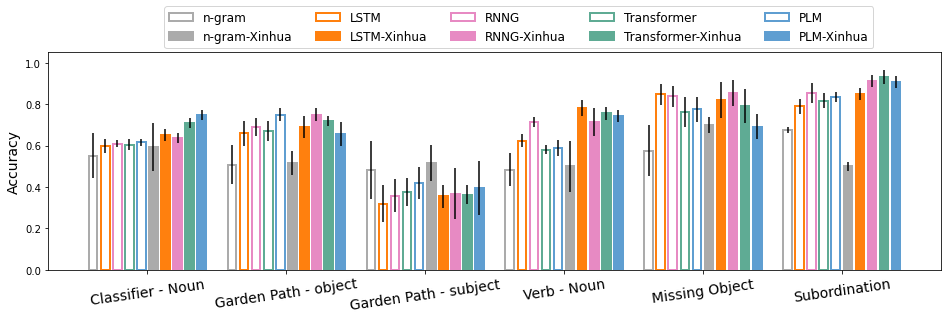

In [17]:
# new transformer
ind = [0,1.6,3.2,4.8,6.4,8.0] # the x locations for the groups
length = 16
width = 4
bar_width = 0.1  # the width of the bars
alpha = [0.6,0.6,0.6,0.6,0.6,1,1,1,1,1]
cb_safe = ['#ABABAB','#FF800E','#e78ac3', '#5FAB94','#5F9ED1', '#ABABAB','#FF800E','#e78ac3', '#5FAB94','#5F9ED1']
fill_color = ['white','white','white','white','white','#ABABAB','#FF800E','#e78ac3', '#5FAB94','#5F9ED1']
models_fn = ['n-gram','LSTM','RNNG','Transformer','PLM','n-gram-Xinhua','LSTM-Xinhua','RNNG-Xinhua','Transformer-Xinhua','PLM-Xinhua']
margin = [-9,-7,-5,-3,-1,1,3,5,7,9]
margin = [i*1/(6*2.4) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(10): 
#     print(ind[0] + margin[i],ind[1] + margin[i],ind[2] + margin[i],ind[3] + margin[i],ind[4] + margin[i],ind[5] + margin[i])
    n = len(dic_by_mt[('Classifier',models_fn[i])])
    rects1 = ax.bar(ind[0] + margin[i], np.mean(dic_by_mt[('Classifier',models_fn[i])]), bar_width, yerr=1.96*np.std(dic_by_mt[('Classifier',models_fn[i])])/np.sqrt(n),
                    label=models_fn[i], color=fill_color[i], edgecolor = cb_safe[i],linewidth=2)
    n = len(dic_by_mt[('GP_obj',models_fn[i])])
    rects2 = ax.bar(ind[1] + margin[i], np.mean(dic_by_mt[('GP_obj',models_fn[i])]), bar_width, yerr=1.96*np.std(dic_by_mt[('GP_obj',models_fn[i])])/np.sqrt(n),
                    color=fill_color[i],  edgecolor = cb_safe[i],linewidth=2)
    n = len(dic_by_mt[('GP_sub',models_fn[i])])
    rects3 = ax.bar(ind[2] + margin[i], np.mean(dic_by_mt[('GP_sub',models_fn[i])]), bar_width, yerr=1.96*np.std(dic_by_mt[('GP_sub',models_fn[i])])/np.sqrt(n),
                    color=fill_color[i],  edgecolor = cb_safe[i],linewidth=2)
    n = len(dic_by_mt[('Verb_Noun',models_fn[i])])
    rects4 = ax.bar(ind[3] + margin[i], np.mean(dic_by_mt[('Verb_Noun',models_fn[i])]), bar_width, yerr=1.96*np.std(dic_by_mt[('Verb_Noun',models_fn[i])])/np.sqrt(n),
                    color=fill_color[i],  edgecolor = cb_safe[i],linewidth=2)
    n = len(dic_by_mt[('Missing_Object',models_fn[i])])
    rects5 = ax.bar(ind[4] + margin[i], np.mean(dic_by_mt[('Missing_Object',models_fn[i])]), bar_width, yerr=1.96*np.std(dic_by_mt[('Missing_Object',models_fn[i])])/np.sqrt(n),
                    color=fill_color[i],  edgecolor = cb_safe[i],linewidth=2)
    n = len(dic_by_mt[('Subordination',models_fn[i])])
    rects6 = ax.bar(ind[5] + margin[i], np.mean(dic_by_mt[('Subordination',models_fn[i])]), bar_width, yerr=1.96*np.std(dic_by_mt[('Subordination',models_fn[i])])/np.sqrt(n),
                    color=fill_color[i],  edgecolor = cb_safe[i],linewidth=2)
ax.set_ylabel('Accuracy',fontsize=14)

ax.set_xticks(ind)
ax.set_xticklabels(('Classifier - Noun','Garden Path - object','Garden Path - subject','Verb - Noun','Missing Object','Subordination'),rotation=8,fontsize=14)
order = [0,5,1,6,2,7,3,8,4,9]
handles, labels = plt.gca().get_legend_handles_labels()
lgd=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.13,1.02), ncol=5,fontsize=12)
plt.ylim(0.0,1.05)
plt.savefig(fname='acc_by_testnmodel_ave4_new.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

---

### Figure 2:  Mean accuracy scores by model type across all test suites

10


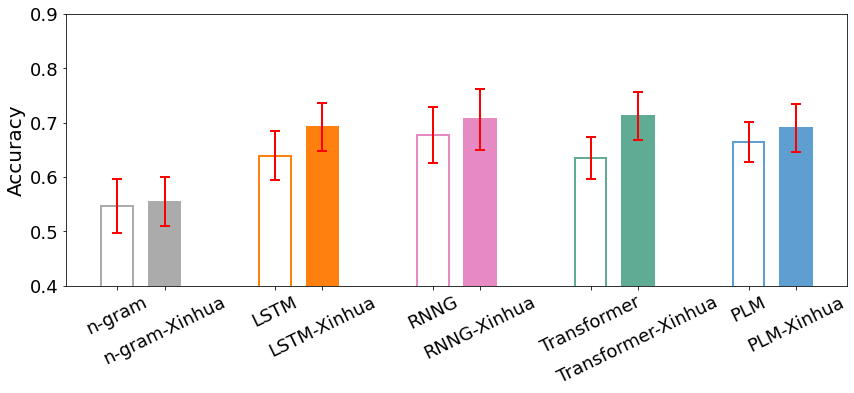

In [128]:
length = 14*0.95
width = 5*0.95
# hatch = "//",
data = [dic_by_model[i] for i in labels if i!='']
data_mean = [np.mean(i) for i in data]
print(len(data_mean))
data_ci = [1.96*np.std(i)/np.sqrt(len(i)) for i in data]
fig, ax = plt.subplots(figsize=(length,width))
ind=[0,1,2,3,4,0.3,1.3,2.3,3.3,4.3]
for i in range(10):
    ax.bar(ind[i],data_mean[i],width=0.2,color=fill_color[i], yerr=data_ci[i],error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2), edgecolor = cb_safe[i], linewidth=2)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(models_fn,fontsize=18,rotation=28)
ax.tick_params(axis="y", labelsize=18)
plt.ylim([0.4,0.9])

plt.savefig(fname='acc_by_model4_bar_new.pdf',bbox_inches='tight',dpi=300)

-----

### Figure 3: Accuracy on Missing Object as function of modifier complexity, for each model class

In [54]:
def compute_slope(mean_acc1, mean_acc2):
    return (mean_acc2 - mean_acc1)/3

ngram :  [0.0, 0.0, 0.0, 0.0]   Xinhua_ngram :  [0.0, 0.0, 0.0, 0.0]
lstm :  [0.018105704441786663, 0.04752747415969, 0.018105704441786663, 0.061106752491029995]   Xinhua_lstm :  [0.03507980235596166, 0.030553376245514997, 0.07129121123953498, 0.09392334179176834]
rnng :  [0.09285726250541741, 0.04573566660714589, 0.04573566660714589, 0.06929646455628166]   Xinhua_rnng :  [0.04573566660714589, 0.0, 0.023560797949135764, 0.04573566660714589]
transformer :  [0.018105704441786663, 0.07694924387759333, 0.08147566998803998, 0.030553376245514997]   Xinhua_transformer :  [0.018105704441786663, 0.06450157207386499, 0.07129121123953498, 0.018105704441786663]
plm :  [0.0, 0.018105704441786663, 0.03507980235596166, 0.07694924387759333]   Xinhua_plm :  [0.06450157207386499, 0.018105704441786663, 0.04752747415969, 0.08147566998803998]


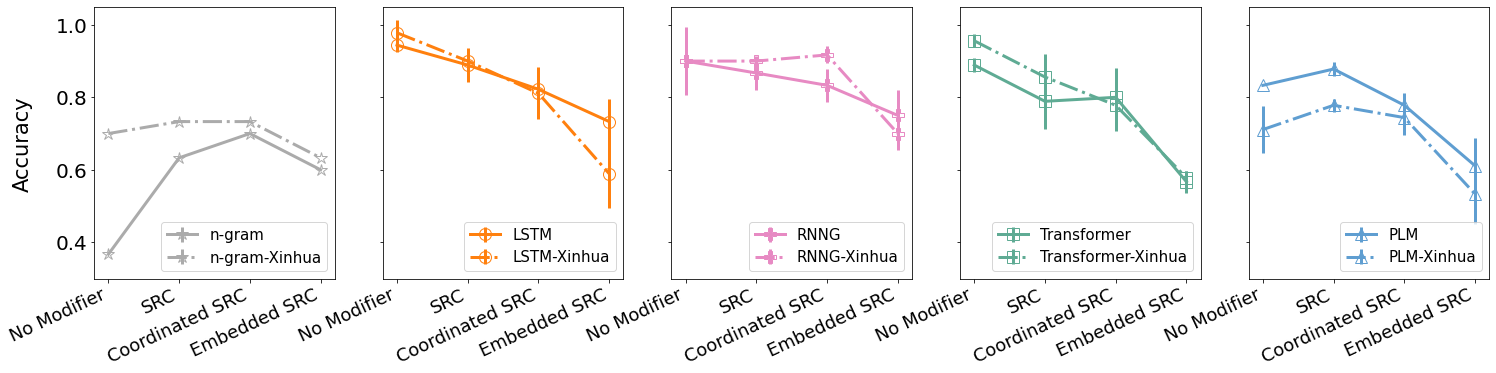

In [55]:
ind = np.arange(4)  # the x locations for the groups
length = 11
width = 7
style = ['-','-','-','-','-','-.','-.','-.','-.','-.']
marker = ['*','o','P','s','^','*','o','P','s','^']
models_table = ['ngram','lstm','rnng','transformer','plm','Xinhua_ngram','Xinhua_lstm','Xinhua_rnng','Xinhua_transformer','Xinhua_plm']
n_table = [1,3,2,3,3]
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(25,5))
axes = [ax1,ax2,ax3,ax4,ax5]
slope_dict={}
for i in range(5):   
    small_i = i
    large_i = i+5
    n = n_table[i]
    small_yerr_list = []
    large_yerr_list = []
    for j in [16,17,18,19]:
        yerr=1.96*df_tables[j].loc[models_table[small_i]]['Standard Deviation']/np.sqrt(n)
        small_yerr_list.append(yerr)
        yerr=1.96*df_tables[j].loc[models_table[large_i]]['Standard Deviation']/np.sqrt(n)
        large_yerr_list.append(yerr)
    slope_dict[models_table[small_i]] = small_yerr_list
    slope_dict[models_table[large_i]] = large_yerr_list
    print(models_table[small_i],": ", small_yerr_list," ",models_table[large_i],": ",large_yerr_list)
    small_data = [df_tables[16].loc[df_tables[16].index[small_i]][0], df_tables[17].loc[df_tables[16].index[small_i]][0], df_tables[18].loc[df_tables[16].index[small_i]][0], 
            df_tables[19].loc[df_tables[16].index[small_i]][0]]
    large_data = [df_tables[16].loc[df_tables[16].index[large_i]][0], df_tables[17].loc[df_tables[16].index[large_i]][0], df_tables[18].loc[df_tables[16].index[large_i]][0], 
            df_tables[19].loc[df_tables[16].index[large_i]][0]]
    small_slope = compute_slope(df_tables[16].loc[models_table[small_i]]['Mean Accuracy'],df_tables[19].loc[models_table[small_i]]['Mean Accuracy'])
    large_slope = compute_slope(df_tables[16].loc[models_table[large_i]]['Mean Accuracy'],df_tables[19].loc[models_table[large_i]]['Mean Accuracy'])
    average_slope = np.round((small_slope+large_slope)/2,2)
    axes[i].errorbar(x=ind, y=small_data,yerr=small_yerr_list,
             marker=marker[small_i],
                    label=models_fn[small_i], markersize=12,ls=style[small_i],markerfacecolor='none',color=cb_safe[small_i], linewidth=3)
    axes[i].errorbar(x=ind, y=large_data, yerr=large_yerr_list,marker=marker[large_i],
                    label=models_fn[large_i], markersize=12,ls=style[large_i],markerfacecolor='none',color=cb_safe[large_i], linewidth=3)
    axes[i].tick_params(axis="y", labelsize=20)
#     axes[i].set_title('Average Slope: ' + str(average_slope), fontsize=20)
    axes[i].set_xticks(ind)
    axes[i].set_xlim(-0.2,3.2)
    axes[i].set_xticklabels(('No Modifier','SRC','Coordinated SRC','Embedded SRC'),rotation=25,fontsize=18,ha='right')
    axes[i].legend(loc='lower right',fontsize=15)
plt.ylim(0.3,1.05)
fig.text(0.08, 0.5, 'Accuracy', va='center', rotation='vertical',fontsize=21)
plt.savefig(fname='missing_obj_line4_split.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

---

### Figure 4.a: Mean surprisal difference at target region - GP Object

In [24]:
data_gpo = []
dict_gpo_sp = {}
for i in range(10):
    diff = surprisal_difference(paths[i],models_fn[i],'gpo')
    n = len(diff)
    diff_mean = np.mean(diff)
    diff_std = np.std(diff)
    ci = 1.96*diff_std/np.sqrt(n)
    data_gpo.append([diff_mean,ci])
    dict_gpo_sp[models_fn[i]] = diff

['../OpenMind/ngram_outputs/trial0/']
['../OpenMind/lstm_outputs/trial0/', '../OpenMind/lstm_outputs/trial1/', '../OpenMind/lstm_outputs/trial2/']
['../OpenMind/rnng_outputs/trial0/', '../OpenMind/rnng_outputs/trial2/']
['../OpenMind/trans_outputs/trial0/', '../OpenMind/trans_outputs/trial1/', '../OpenMind/trans_outputs/trial2/']
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
['../OpenMind/hybrid1_outputs_ngram/trial0/']
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']


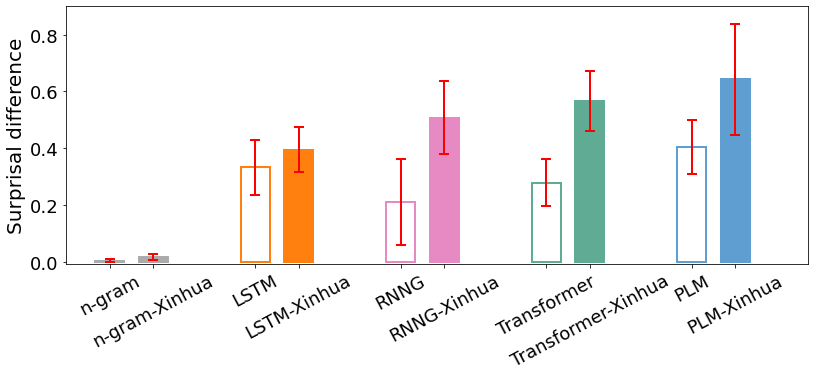

In [133]:
length = 14*0.95
width = 5*0.95
hatch = ["","","","","","//","//","//","//","//"]
fig, ax = plt.subplots(figsize=(length,width))
ind=[0,1,2,3,4,0.3,1.3,2.3,3.3,4.3]
for i in range(10):
    ax.bar(ind[i],data_gpo[i][0],width=0.2,color=fill_color[i], edgecolor = cb_safe[i], linewidth=2,yerr=data_gpo[i][1],error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
ax.set_ylabel('Surprisal difference',fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(models_fn,fontsize=18,rotation=28)
ax.tick_params(axis="y", labelsize=18)
plt.ylim(-0.01,0.9)
x_coordinates = [-0.3, 4.8]
y_coordinates = [0, 0]
plt.xlim([-0.3,4.8])
plt.savefig(fname='surp_diff_gpo_new.pdf', bbox_inches='tight')

### Figure 4.b: Mean surprisal difference at target region - GP Subject

In [26]:
data_gps = []
dict_gps_sp = {}
diff_gps_list = []
for i in range(10):
    diff = surprisal_difference(paths[i],models_fn[i],'gps')
    n = len(diff)
    diff_mean = np.mean(diff)
    diff_std = np.std(diff)
    ci = 1.96*diff_std/np.sqrt(n)
    data_gps.append([diff_mean,ci,diff_std])
    dict_gps_sp[models_fn[i]] = diff
    diff_gps_list.append(diff)

['../OpenMind/ngram_outputs/trial0/']
['../OpenMind/lstm_outputs/trial0/', '../OpenMind/lstm_outputs/trial1/', '../OpenMind/lstm_outputs/trial2/']
['../OpenMind/rnng_outputs/trial0/', '../OpenMind/rnng_outputs/trial2/']
['../OpenMind/trans_outputs/trial0/', '../OpenMind/trans_outputs/trial1/', '../OpenMind/trans_outputs/trial2/']
['../OpenMind/plm_outputs/trial0/', '../OpenMind/plm_outputs/trial1/', '../OpenMind/plm_outputs/trial2/']
['../OpenMind/hybrid1_outputs_ngram/trial0/']
['../OpenMind/hybrid1_outputs/trial0/', '../OpenMind/hybrid1_outputs/trial1/', '../OpenMind/hybrid1_outputs/trial2/']
['../OpenMind/hybrid1_outputs_rnng/trial0/', '../OpenMind/hybrid1_outputs_rnng/trial1/']
['../OpenMind/hybrid1_outputs_trans/trial0/', '../OpenMind/hybrid1_outputs_trans/trial1/', '../OpenMind/hybrid1_outputs_trans/trial2/']
['../OpenMind/hybrid1_outputs_plm/trial0/', '../OpenMind/hybrid1_outputs_plm/trial1/', '../OpenMind/hybrid1_outputs_plm/trial2/']


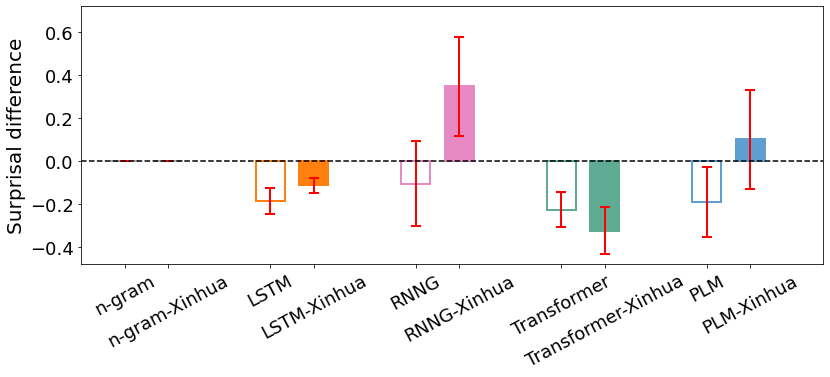

In [131]:
length = 14*0.95
width = 5*0.95
# hatch = "//",
fig, ax = plt.subplots(figsize=(length,width))
ind=[0,1,2,3,4,0.3,1.3,2.3,3.3,4.3]
for i in range(10):
    ax.bar(ind[i],data_gps[i][0],width=0.2,color=fill_color[i], edgecolor = cb_safe[i], linewidth=2,yerr=data_gps[i][1],error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
ax.set_ylabel('Surprisal difference',fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(models_fn,fontsize=18,rotation=28)
ax.tick_params(axis="y", labelsize=18)
plt.ylim(-0.48,0.72)
x_coordinates = [-0.3, 4.8]
y_coordinates = [0, 0]
plt.xlim([-0.3,4.8])
plt.plot(x_coordinates, y_coordinates,'k--')
plt.savefig(fname='surp_diff_gps_new.pdf', bbox_inches='tight')

---

### Prepare data for linear mixed-effects analysis

In [33]:
# prepare data for lmer data size
small_lstm = dic_by_model['LSTM'] 
small_lstm_seed = [1,2,3]*24
small_lstm_large = [0]*72
small_lstm_models = ['LSTM']*72
small_lstm_modifier = ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 +  ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + \
 ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Sub']*3+['Sub2']*3+['Subh']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3
large_lstm = dic_by_model['LSTM-Xinhua'] 
large_lstm_seed = [1,2,3]*24
large_lstm_large = [1]*72
large_lstm_models = ['LSTM']*72
large_lstm_modifier = ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 +  ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + \
 ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Sub']*3+['Sub2']*3+['Subh']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3

small_rnng = dic_by_model['RNNG'] 
small_rnng_seed = [1,2]*24
small_rnng_large = [0]*48
small_rnng_models = ['RNNG']*48
small_rnng_modifier = ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 + ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 +  ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 + \
 ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 + ['None']*2+['Sub']*2+['Sub2']*2+['Subh']*2 + ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2
large_rnng = dic_by_model['RNNG-Xinhua'] 
large_rnng_seed = [1,2]*24
large_rnng_large = [1]*48
large_rnng_models = ['RNNG']*48
large_rnng_modifier = ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 + ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 +  ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 + \
 ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2 + ['None']*2+['Sub']*2+['Sub2']*2+['Subh']*2 + ['None']*2+['Adj']*2+['Obj']*2+['Sub']*2


small_trans = dic_by_model['Transformer'] 
small_trans_seed = [1,2,3]*24
small_trans_large = [0]*72
small_trans_models = ['Transformer']*72
small_trans_modifier = ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 +  ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + \
 ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Sub']*3+['Sub2']*3+['Subh']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3
large_trans = dic_by_model['Transformer-Xinhua'] 
large_trans_seed = [1,2,3]*24
large_trans_large = [1]*72
large_trans_models = ['Transformer']*72
large_trans_modifier = ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 +  ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + \
 ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Sub']*3+['Sub2']*3+['Subh']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3


small_plm = dic_by_model['PLM'] 
small_plm_seed = [1,2,3]*24
small_plm_large = [0]*72
small_plm_models = ['PLM']*72
small_plm_modifier = ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 +  ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + \
 ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Sub']*3+['Sub2']*3+['Subh']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3
large_plm = dic_by_model['PLM-Xinhua'] 
large_plm_seed = [1,2,3]*24
large_plm_large = [1]*72
large_plm_models = ['PLM']*72
large_plm_modifier = ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 +  ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + \
 ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3 + ['None']*3+['Sub']*3+['Sub2']*3+['Subh']*3 + ['None']*3+['Adj']*3+['Obj']*3+['Sub']*3

test = [j for i in [['Classifier']*12+['GP_obj']*12+['GP_sub']*12+['Verb_Noun']*12+['MObj']*12+['Subordination']*12 ]*2 for j in i] + \
[j for i in [['Classifier']*8+['GP_obj']*8+['GP_sub']*8+['Verb_Noun']*8+['MObj']*8+['Subordination']*8 ]*2 for j in i] + \
[j for i in [['Classifier']*12+['GP_obj']*12+['GP_sub']*12+['Verb_Noun']*12+['MObj']*12+['Subordination']*12 ]*4 for j in i]
data_size_acc = small_lstm+large_lstm+small_rnng+large_rnng+small_trans+large_trans+small_plm+large_plm
data_size_seed = small_lstm_seed+large_lstm_seed+small_rnng_seed+large_rnng_seed+small_trans_seed+large_trans_seed+small_plm_seed+large_plm_seed
data_size_large = small_lstm_large+large_lstm_large+small_rnng_large+large_rnng_large+small_trans_large+large_trans_large+small_plm_large+large_plm_large
data_size_models = small_lstm_models+large_lstm_models+small_rnng_models+large_rnng_models+small_trans_models+large_trans_models+small_plm_models+large_plm_models
data_size_modifier = small_lstm_modifier+large_lstm_modifier+small_rnng_modifier+large_rnng_modifier+small_trans_modifier+large_trans_modifier+small_plm_modifier+large_plm_modifier
data_size_df = pd.DataFrame({"accuracy":data_size_acc,'class':test,'large':data_size_large,'seed':data_size_seed,'model':data_size_models,'modifier':data_size_modifier})
data_size_df.to_csv('data_size_df.csv')


In [34]:
data_size_df

,accuracy,class,large,seed,model,modifier
0,0.758000,Classifier,0,1,LSTM,None
1,0.600000,Classifier,0,2,LSTM,None
2,0.642000,Classifier,0,3,LSTM,None
3,0.583000,Classifier,0,1,LSTM,Adj
4,0.625000,Classifier,0,2,LSTM,Adj
...,...,...,...,...,...,...
523,0.933333,Subordination,1,2,PLM,Obj
524,0.866667,Subordination,1,3,PLM,Obj
525,0.866667,Subordination,1,1,PLM,Sub
526,0.800000,Subordination,1,2,PLM,Sub


In [35]:
# prepare data for lmer - Mobj:

# lstm
lstm_accuracy = dic_by_mt[('Missing_Object','LSTM')] + dic_by_mt[('Missing_Object','LSTM-Xinhua')]
lstm_model = ['LSTM'] * len(lstm_accuracy)
lstm_seed = [1,2,3]*8
lstm_modifier = ["None"]*3 + ["Sub"]*3 + ["Sub2"]*3 + ["Subh"]*3 + ["None"]*3 + ["Sub"]*3 + ["Sub2"]*3 + ["Subh"]*3
lstm_data = [0] * len(dic_by_mt[('Missing_Object','LSTM')]) + [1] * len(dic_by_mt[('Missing_Object','LSTM-Xinhua')])
# rnng
rnng_accuracy = dic_by_mt[('Missing_Object','RNNG')] + dic_by_mt[('Missing_Object','RNNG-Xinhua')]
rnng_model = ['RNNG'] * len(rnng_accuracy)
rnng_seed = [1,2]*8
rnng_modifier = ["None"]*2 + ["Sub"]*2 + ["Sub2"]*2 + ["Subh"]*2 + ["None"]*2 + ["Sub"]*2 + ["Sub2"]*2 + ["Subh"]*2
rnng_data = [0] * len(dic_by_mt[('Missing_Object','RNNG')]) + [1] * len(dic_by_mt[('Missing_Object','RNNG-Xinhua')])
# trans
trans_accuracy = dic_by_mt[('Missing_Object','Transformer')] + dic_by_mt[('Missing_Object','Transformer-Xinhua')]
trans_model = ['Transformer'] * len(trans_accuracy)
trans_seed = [1,2,3]*8
trans_modifier = ["None"]*3 + ["Sub"]*3 + ["Sub2"]*3 + ["Subh"]*3 + ["None"]*3 + ["Sub"]*3 + ["Sub2"]*3 + ["Subh"]*3
trans_data = [0] * len(dic_by_mt[('Missing_Object','Transformer')]) + [1] * len(dic_by_mt[('Missing_Object','Transformer-Xinhua')])
# plm
plm_accuracy = dic_by_mt[('Missing_Object','PLM')] + dic_by_mt[('Missing_Object','PLM-Xinhua')]
plm_model = ['PLM'] * len(plm_accuracy)
plm_seed = [1,2,3]*8
plm_modifier = ["None"]*3 + ["Sub"]*3 + ["Sub2"]*3 + ["Subh"]*3 + ["None"]*3 + ["Sub"]*3 + ["Sub2"]*3 + ["Subh"]*3
plm_data = [0] * len(dic_by_mt[('Missing_Object','PLM')]) + [1] * len(dic_by_mt[('Missing_Object','PLM-Xinhua')])


In [37]:
accuracy = lstm_accuracy+rnng_accuracy+trans_accuracy+plm_accuracy
model = lstm_model+rnng_model+trans_model+plm_model
seed = lstm_seed+rnng_seed+trans_seed+plm_seed
modifier = lstm_modifier+rnng_modifier+trans_modifier+plm_modifier
data = lstm_data+rnng_data+trans_data+plm_data
mobj_df = pd.DataFrame({"accuracy": accuracy,"data":data, "model":model,"seed":seed,"modifier":modifier})
mobj_df.to_csv("Missing_Object.csv")

In [287]:
mobj_df

,accuracy,data,model,seed,modifier
0,0.933333,0,LSTM,1,None
1,0.933333,0,LSTM,2,None
2,0.966667,0,LSTM,3,None
3,0.833333,0,LSTM,1,Sub
4,0.900000,0,LSTM,2,Sub
...,...,...,...,...,...
83,0.733333,1,PLM,2,Sub2
84,0.700000,1,PLM,3,Sub2
85,0.600000,1,PLM,1,Subh
86,0.566667,1,PLM,2,Subh


In [39]:
# prepare data for lmer - Subordination: dic_by_mt [seed1_none,seed2_none,seed3_none]
model = [0] * len(dic_by_mt[('Subordination','LSTM-Xinhua')]) + [1] * len(dic_by_mt[('Subordination','RNNG')])
seed = [1,2,3] * 4 + [1,2]*4
modifier = ["None"] * 3 + ["Adj"] * 3 + ["ORC"] * 3 + ["SRC"] * 3 + ["None"] * 2 + ["Adj"] * 2 + ["ORC"] * 2 + ["SRC"] * 2
subordination_df = pd.DataFrame({"accuracy": dic_by_mt[('Subordination','LSTM-Xinhua')] + dic_by_mt[('Subordination','RNNG')],
                                "model": model, "seed": seed, "modifier":modifier})
subordination_df.to_csv("subordination.csv")


In [40]:
subordination_df # p-value 0.337

,accuracy,model,seed,modifier
0,0.900000,0,1,None
1,0.900000,0,2,None
2,0.900000,0,3,None
3,0.866667,0,1,Adj
4,0.766667,0,2,Adj
5,0.900000,0,3,Adj
6,0.833333,0,1,ORC
7,0.766667,0,2,ORC
8,0.900000,0,3,ORC
9,0.866667,0,1,SRC


In [86]:
# compare syntactic and semantic test suites - exclude n-gram models no modifiers
semantic_list_nonomd = [dic_by_mt_none[('Classifier',i)] + dic_by_mt_none[('Verb_Noun',i)] for i in models_fn if i != 'n-gram' and i != 'n-gram-Xinhua']
semantic_list_nonomd = [j for i in semantic_list_nonomd for j in i]
semantic_n_nonomd = len(semantic_list_nonomd)
semantic_mean_nonomd = np.mean(semantic_list_nonomd)
semantic_std_nonomd = np.std(semantic_list_nonomd)
semantic_err_nonomd = 1.96*semantic_std_nonomd/np.sqrt(semantic_n_nonomd)


syntactic_list_nonomd = [dic_by_mt_none[('Missing_Object',i)] + dic_by_mt_none[('Subordination',i)] for i in models_fn if i != 'n-gram' and i != 'n-gram-Xinhua']
syntactic_list_nonomd = [j for i in syntactic_list_nonomd for j in i]
syntactic_n_nonomd = len(syntactic_list_nonomd)
syntactic_mean_nonomd = np.mean(syntactic_list_nonomd)
syntactic_std_nonomd = np.std(syntactic_list_nonomd)
syntactic_err_nonomd = 1.96*syntactic_std_nonomd/np.sqrt(syntactic_n_nonomd)

# compare syntactic and semantic test suites - exclude n-gram models average modifiers
semantic_list_no = [dic_by_mt[('Classifier',i)] + dic_by_mt[('Verb_Noun',i)] for i in models_fn if i != 'n-gram' and i != 'n-gram-Xinhua']
semantic_list_no = [j for i in semantic_list_no for j in i]
semantic_n_no = len(semantic_list_no)
semantic_mean_no = np.mean(semantic_list_no)
semantic_std_no = np.std(semantic_list_no)
semantic_err_no = 1.96*semantic_std_no/np.sqrt(semantic_n_no)

syntactic_list_no = [dic_by_mt[('Missing_Object',i)] + dic_by_mt[('Subordination',i)] for i in models_fn if i != 'n-gram' and i != 'n-gram-Xinhua']
syntactic_list_no = [j for i in syntactic_list_no for j in i]
syntactic_n_no = len(syntactic_list_no)
syntactic_mean_no = np.mean(syntactic_list_no)
syntactic_std_no = np.std(syntactic_list_no)
syntactic_err_no = 1.96*syntactic_std_no/np.sqrt(syntactic_n_no)


In [109]:
# prepare data for lmer - syntactic v.s. semantic test suites
syntactic_indicator = [0] * semantic_n_no + [1] * syntactic_n_no
models = [j for i in [['LSTM']*3*4*2+['RNNG']*2*4*2+['Transformer']*3*4*2+['PLM']*3*4*2+['LSTM-Xinhua']*3*4*2+['RNNG-Xinhua']*2*4*2+['Transformer-Xinhua']*3*4*2+['PLM-Xinhua']*3*4*2] * 2 for j in i ] # modfiers*2 classes * syn+sem
seed = ([1,2,3]*4*2 + [1,2]*4*2 + [1,2,3]*4*2 + [1,2,3]*4*2 + [1,2,3]*4*2 + [1,2]*4*2 + [1,2,3]*4*2 + [1,2,3]*4*2)*2

# first two rows: ctb_models; first row: LSTM * 2(cn+vn) + RNNG * 2(cn+vn)
sem_modifiers = [['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3]*2 + [['None']*2 + ['Adj']*2 + ['ORC']*2 + ['SRC']*2]*2 + \
[['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3]*2 + [['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3]*2 + \
[['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3]*2 + [['None']*2 + ['Adj']*2 + ['ORC']*2 + ['SRC']*2]*2 + \
[['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3]*2 + [['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3]*2 
# first row: lstm
syn_modifiers_ctb = [['None']*3 + ['Sub']*3 + ['Sub2']*3 + ['Subh']*3 + ['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3 + \
                ['None']*2 + ['Sub']*2 + ['Sub2']*2 + ['Subh']*2 + ['None']*2 + ['Adj']*2 + ['ORC']*2 + ['SRC']*2 + \
                ['None']*3 + ['Sub']*3 + ['Sub2']*3 + ['Subh']*3 + ['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3 + \
                ['None']*3 + ['Sub']*3 + ['Sub2']*3 + ['Subh']*3 + ['None']*3 + ['Adj']*3 + ['ORC']*3 + ['SRC']*3]
syn_modifiers = syn_modifiers_ctb + syn_modifiers_ctb
sem_modifiers = [j for i in sem_modifiers for j in i]
syn_modifiers = [j for i in syn_modifiers for j in i]

modifiers = sem_modifiers + syn_modifiers
accuracy = semantic_list_no + syntactic_list_no
syn_sem_ave = pd.DataFrame({'accuracy':accuracy,'syn':syntactic_indicator,'model':models,'seed':seed,'modifier':modifiers})
syn_sem_ave.to_csv('syn_sem_ave.csv')

In [111]:
syntactic_indicator = [0] * semantic_n_nonomd + [1] * syntactic_n_nonomd
models = [j for i in [['LSTM']*3*2+['RNNG']*2*2+['Transformer']*3*2+['PLM']*3*2+['LSTM-Xinhua']*3*2+['RNNG-Xinhua']*2*2+['Transformer-Xinhua']*3*2+['PLM-Xinhua']*3*2] * 2 for j in i ] # modfiers*2 classes * syn+sem
seed = ([1,2,3]*2 + [1,2]*2 + [1,2,3]*2 + [1,2,3]*2 + [1,2,3]*2 + [1,2]*2 + [1,2,3]*2 + [1,2,3]*2)*2 # first x2: two test suite classes; second x2: syn+sem
accuracy = semantic_list_nonomd + syntactic_list_nonomd
syn_sem_no = pd.DataFrame({'accuracy':accuracy,'syn':syntactic_indicator,'model':models,'seed':seed})
syn_sem_no.to_csv('syn_sem_no.csv')


---

### Appendix Figure 6: Accuracy on semantic and syntactic test suite classes, with and without intervening content

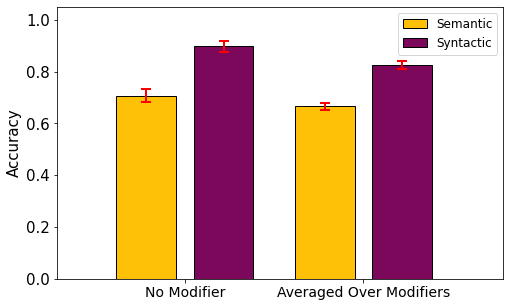

In [118]:
length = 8
width = 5
# hatch = "//",
fig, ax = plt.subplots(figsize=(length,width))
ax.bar(0.3,semantic_mean_nonomd,label='Semantic',width=0.2,edgecolor = 'black',color = '#FFC107',yerr=semantic_err_nonomd,error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
ax.bar(0.56,syntactic_mean_nonomd,label='Syntactic',width=0.2,edgecolor = 'black',color = '#7C085C',yerr=syntactic_err_nonomd,error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
ax.bar(0.9,semantic_mean_no,width=0.2,edgecolor = 'black',color = '#FFC107',yerr=semantic_err_no,error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
ax.bar(1.16,syntactic_mean_no,width=0.2,edgecolor = 'black',color = '#7C085C',yerr=syntactic_err_no,error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
ax.set_ylabel('Accuracy',fontsize=15)
ax.set_xticks([0.43,1.03])
ax.set_xticklabels(['No Modifier','Averaged Over Modifiers'],fontsize=14)
ax.tick_params(axis="y", labelsize=15)
plt.legend(fontsize=12)
plt.ylim(0.0,1.05)
plt.xlim(0,1.5)
plt.savefig(fname='sem_syn_new.pdf', bbox_inches='tight')

---

### Appendix Table 6: Accuracy score by model and test suite class

In [18]:
# full table
cls_models = []
gpo_models = []
gps_models = []
vn_models = []
mobj_models = []
subn_models = []
for i in range(10):
    cls = dic_by_mt[('Classifier',models_fn[i])]
    gpo = dic_by_mt[('GP_obj',models_fn[i])]
    gps = dic_by_mt[('GP_sub',models_fn[i])]
    vn = dic_by_mt[('Verb_Noun',models_fn[i])]
    mobj = dic_by_mt[('Missing_Object',models_fn[i])]
    subn = dic_by_mt[('Subordination',models_fn[i])]
    cls_models.append(np.round(np.mean(cls),3))
    gpo_models.append(np.round(np.mean(gpo),3))
    gps_models.append(np.round(np.mean(gps),3))
    vn_models.append(np.round(np.mean(vn),3))
    mobj_models.append(np.round(np.mean(mobj),3))
    subn_models.append(np.round(np.mean(subn),3))

full_statistics = pd.DataFrame({'Classifier': cls_models, 'GP_obj': gpo_models, 'GP_sub': gps_models,
                                'Verb_Noun': vn_models, 'Missing_Object': mobj_models, 'Subordination': subn_models})
full_statistics.index = models_fn
full_statistics.style.highlight_max(color = 'lightgreen', axis = 0)

,Classifier,GP_obj,GP_sub,Verb_Noun,Missing_Object,Subordination
n-gram,0.552000,0.508000,0.484000,0.484000,0.575000,0.675000
LSTM,0.598000,0.659000,0.320000,0.624000,0.847000,0.789000
RNNG,0.609000,0.690000,0.359000,0.714000,0.838000,0.854000
Transformer,0.603000,0.672000,0.376000,0.581000,0.761000,0.817000
PLM,0.615000,0.750000,0.419000,0.589000,0.775000,0.836000
n-gram-Xinhua,0.594000,0.516000,0.516000,0.500000,0.700000,0.500000
LSTM-Xinhua,0.650000,0.691000,0.355000,0.782000,0.819000,0.850000
RNNG-Xinhua,0.636000,0.750000,0.367000,0.714000,0.854000,0.913000
Transformer-Xinhua,0.708000,0.720000,0.363000,0.755000,0.792000,0.931000
PLM-Xinhua,0.746000,0.656000,0.395000,0.745000,0.692000,0.908000


In [20]:
# small data 
cls_models = []
gpo_models = []
gps_models = []
vn_models = []
mobj_models = []
subn_models = []
for i in range(5):
    cls = dic_by_mt[('Classifier',models_fn[i])]
    gpo = dic_by_mt[('GP_obj',models_fn[i])]
    gps = dic_by_mt[('GP_sub',models_fn[i])]
    vn = dic_by_mt[('Verb_Noun',models_fn[i])]
    mobj = dic_by_mt[('Missing_Object',models_fn[i])]
    subn = dic_by_mt[('Subordination',models_fn[i])]
    cls_models.append(np.mean(cls))
    gpo_models.append(np.mean(gpo))
    gps_models.append(np.mean(gps))
    vn_models.append(np.mean(vn))
    mobj_models.append(np.mean(mobj))
    subn_models.append(np.mean(subn))

full_statistics = pd.DataFrame({'Classifier': cls_models, 'GP_obj': gpo_models, 'GP_sub': gps_models,
                                'Verb_Noun': vn_models, 'Missing_Object': mobj_models, 'Subordination': subn_models})
full_statistics.index = models_fn[:5]
full_statistics.style.highlight_max(color = 'lightgreen', axis = 0)

,Classifier,GP_obj,GP_sub,Verb_Noun,Missing_Object,Subordination
n-gram,0.552000,0.508065,0.483871,0.483871,0.575000,0.675000
LSTM,0.597917,0.658602,0.319892,0.623656,0.847222,0.788889
RNNG,0.609375,0.689516,0.358871,0.713710,0.837500,0.854167
Transformer,0.603500,0.672043,0.376344,0.580645,0.761111,0.816667
PLM,0.615250,0.750000,0.419355,0.588710,0.775000,0.836111


---

### Appendix Figure 7 Accuracy on individual test suites

### Figure 7.a: Classifier-Noun Compatibility

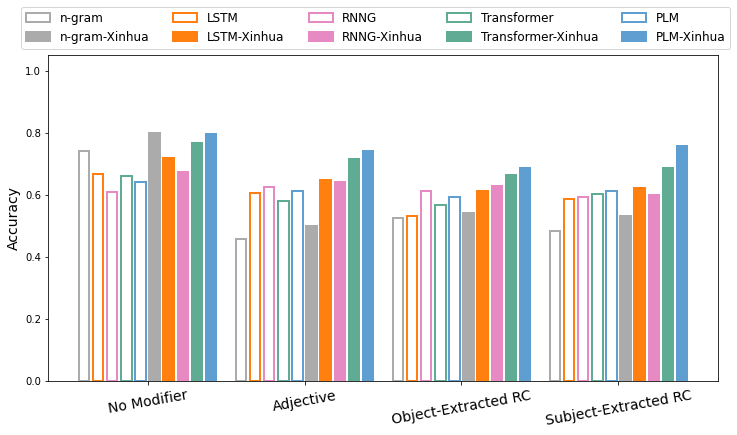

In [57]:
ind = np.arange(4)  # the x locations for the groups
length = 12
width = 6
bar_width = 0.1*(10-6)/width  # the width of the bars
margin = [-9,-7,-5,-3,-1,1,3,5,7,9]
margin = [i*1/(width*3.7) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(10):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[0].loc[df_tables[0].index[i]][4], bar_width,
                    label=models_fn[i], color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects2 = ax.bar(ind[1] + margin[i], df_tables[1].loc[df_tables[1].index[i]][4], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects3 = ax.bar(ind[2] + margin[i], df_tables[2].loc[df_tables[2].index[i]][4], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects4 = ax.bar(ind[3] + margin[i], df_tables[3].loc[df_tables[3].index[i]][4], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adjective','Object-Extracted RC','Subject-Extracted RC'),fontsize=14,rotation=10)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,5,1,6,2,7,3,8,4,9]
lgd=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(-0.04,1.02), ncol=5,fontsize=12)
plt.ylim(0.0,1.05)
plt.savefig(fname='cls_acc_final_new.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

### Figure 7.b: Verb-Noun Compatibility

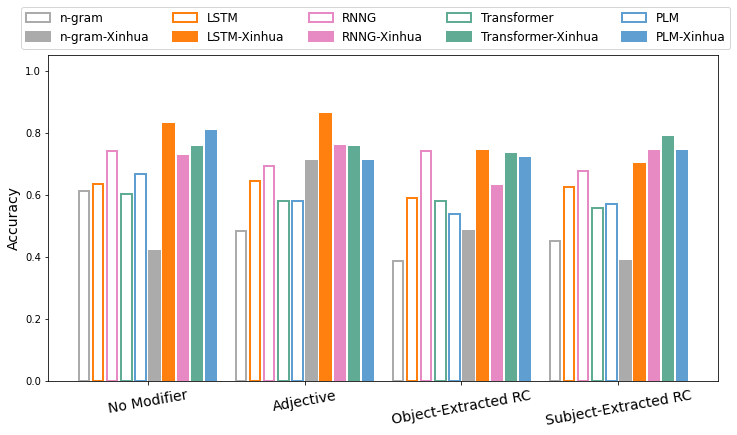

In [58]:
fig, ax = plt.subplots(figsize=(length,width))
for i in range(10):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[12].loc[df_tables[12].index[i]][0], bar_width,
                    label=models_fn[i], color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects2 = ax.bar(ind[1] + margin[i], df_tables[13].loc[df_tables[13].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects3 = ax.bar(ind[2] + margin[i], df_tables[14].loc[df_tables[14].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects4 = ax.bar(ind[3] + margin[i], df_tables[15].loc[df_tables[15].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adjective','Object-Extracted RC','Subject-Extracted RC'),fontsize=14,rotation=10)
handles, labels = plt.gca().get_legend_handles_labels()
lgd=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(-0.04,1.02), ncol=5,fontsize=12)
plt.ylim(0.0,1.05)
plt.savefig(fname='verb_noun_final_new.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

### Figure 7.c Garden Path object

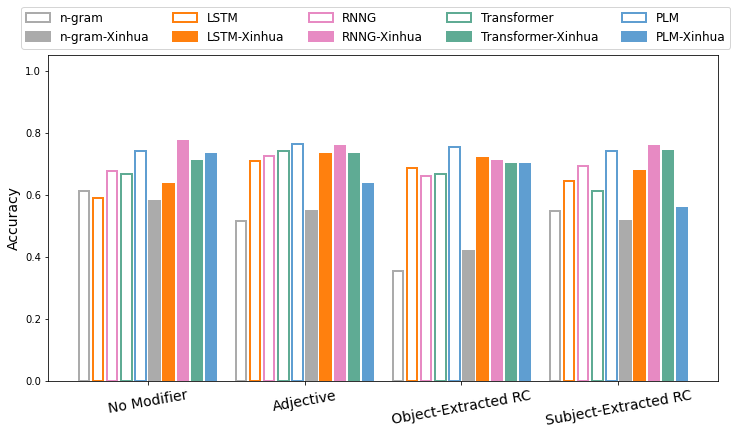

In [59]:
fig, ax = plt.subplots(figsize=(length,width))
for i in range(10):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[4].loc[df_tables[4].index[i]][0], bar_width, 
                    label=models_fn[i], color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects2 = ax.bar(ind[1] + margin[i], df_tables[5].loc[df_tables[5].index[i]][0], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects3 = ax.bar(ind[2] + margin[i], df_tables[6].loc[df_tables[6].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects4 = ax.bar(ind[3] + margin[i], df_tables[7].loc[df_tables[7].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
ax.set_ylabel('Accuracy',fontsize=14)
# ax.set_title('Garden Path - obj Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adjective','Object-Extracted RC','Subject-Extracted RC'),fontsize=14,rotation=10)
handles, labels = plt.gca().get_legend_handles_labels()
lgd=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(-0.04,1.02), ncol=5,fontsize=12)
plt.ylim(0.0,1.05)
plt.savefig(fname='gp_obj_final_new.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

### Figure 7.d: Garden Path subject

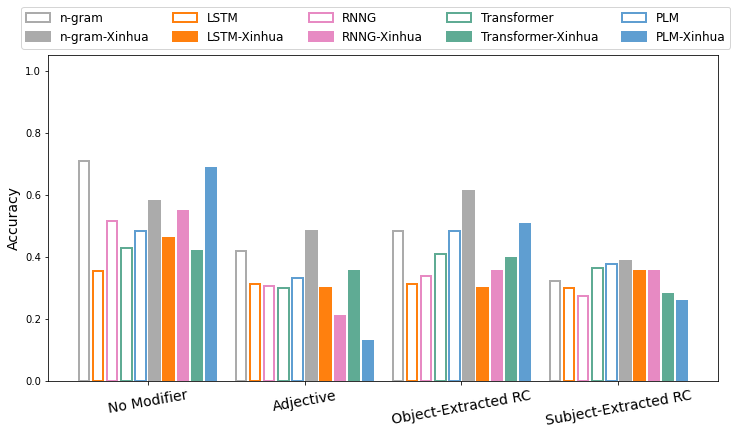

In [60]:
fig, ax = plt.subplots(figsize=(length,width))
for i in range(10):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[8].loc[df_tables[8].index[i]][0], bar_width,
                    label=models_fn[i], color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects2 = ax.bar(ind[1] + margin[i], df_tables[9].loc[df_tables[9].index[i]][0], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects3 = ax.bar(ind[2] + margin[i], df_tables[10].loc[df_tables[10].index[i]][0], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects4 = ax.bar(ind[3] + margin[i], df_tables[11].loc[df_tables[11].index[i]][0], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adjective','Object-Extracted RC','Subject-Extracted RC'),fontsize=14,rotation=10)
handles, labels = plt.gca().get_legend_handles_labels()
lgd=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(-0.04,1.02), ncol=5,fontsize=12)
plt.ylim(0.0,1.05)
plt.savefig(fname='gp_sub_final_new.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

### Figure 7.e: Missing Object

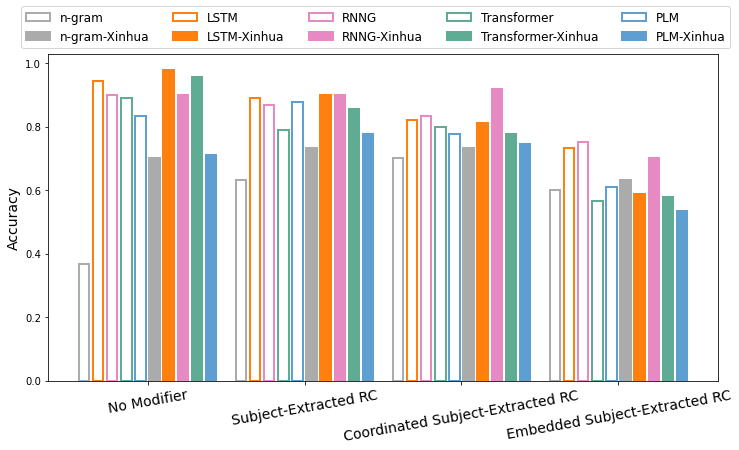

In [61]:
fig, ax = plt.subplots(figsize=(length,width))
for i in range(10):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[16].loc[df_tables[16].index[i]][0], bar_width,
                    label=models_fn[i], color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects2 = ax.bar(ind[1] + margin[i], df_tables[17].loc[df_tables[17].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects3 = ax.bar(ind[2] + margin[i], df_tables[18].loc[df_tables[18].index[i]][0], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects4 = ax.bar(ind[3] + margin[i], df_tables[19].loc[df_tables[19].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_xticks(ind)
handles, labels = plt.gca().get_legend_handles_labels()
ax.set_xticklabels(('No Modifier','Subject-Extracted RC','Coordinated Subject-Extracted RC','Embedded Subject-Extracted RC'),fontsize=14,rotation=10)
handles, labels = plt.gca().get_legend_handles_labels()
lgd=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(-0.04,1.02), ncol=5,fontsize=12)
plt.savefig(fname='missing_obj_final_new.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

### Figure 7.f: Subordination

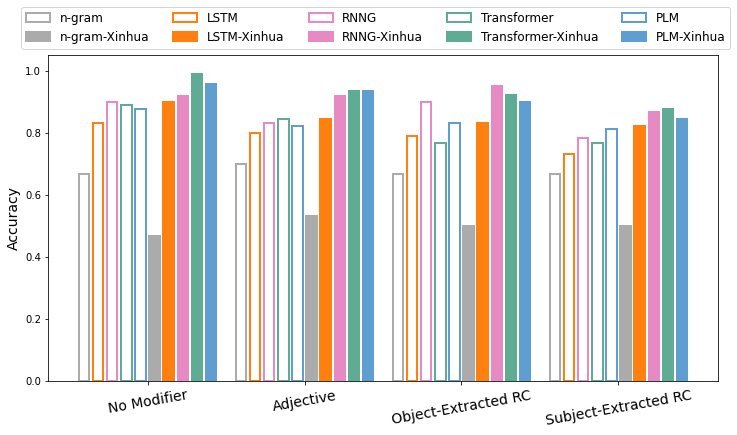

In [63]:
fig, ax = plt.subplots(figsize=(length,width))
for i in range(10):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[20].loc[df_tables[20].index[i]][0], bar_width, 
                    label=models_fn[i], color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects2 = ax.bar(ind[1] + margin[i], df_tables[21].loc[df_tables[21].index[i]][0], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects3 = ax.bar(ind[2] + margin[i], df_tables[22].loc[df_tables[22].index[i]][0], bar_width, 
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
    rects4 = ax.bar(ind[3] + margin[i], df_tables[23].loc[df_tables[23].index[i]][0], bar_width,
                    color=fill_color[i], edgecolor = cb_safe[i], linewidth=2)
ax.set_ylabel('Accuracy',fontsize=14)
# ax.set_title('Subordination Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adjective','Object-Extracted RC','Subject-Extracted RC'),fontsize=14,rotation=10)
handles, labels = plt.gca().get_legend_handles_labels()
lgd=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(-0.04,1.02), ncol=5,fontsize=12)
plt.ylim(0.0,1.05)
plt.savefig(fname='subordination_final_new.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')